# Portfolio Construction

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

import sys

sys.path.insert(1, "../")


from pathlib import Path

from settings import config


import warnings

from scipy.stats import norm, stats

In [2]:
from scipy import stats

In [3]:
from scipy.stats import shapiro, jarque_bera, normaltest, skew, kurtosis

In [4]:
import plotly.io as pio

pio.templates.default = "plotly_white"
warnings.filterwarnings("ignore")

In [5]:
OUTPUT_DIR = Path(config("OUTPUT_DIR"))
DATA_DIR = Path(config("DATA_DIR"))
DATA_DIR = DATA_DIR / "options"
WRDS_USERNAME = config("WRDS_USERNAME")

START_DATE_01 = date(1996, 1, 1)
END_DATE_01 = date(2012, 1, 31)

START_DATE_02 = date(2012, 2, 1)
END_DATE_02 = date(2019, 12, 31)

In [6]:
DATE_RANGE = f"{pd.Timestamp(START_DATE_01):%Y-%m}_{pd.Timestamp(END_DATE_02):%Y-%m}"

## Functions

In [7]:
# --- Black-Scholes elasticity ---
def bs_elasticity(S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    if option_type == "call":
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(
            d1 - sigma * np.sqrt(T)
        )
        delta = norm.cdf(d1)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d1 + sigma * np.sqrt(T)) - S * norm.cdf(
            -d1
        )
        delta = -norm.cdf(-d1)
    return (delta * S / price), price


# Gaussian kernel function
def kernel_weights(m_grid, ttm_grid, k_s, ttm, bw_m=0.0125, bw_t=10):
    m_grid = np.asarray(m_grid, dtype=float)
    ttm_grid = np.asarray(ttm_grid, dtype=float)
    x = (m_grid - k_s) / bw_m
    y = (ttm_grid - ttm) / bw_t
    dist_sq = x**2 + y**2
    weights = np.exp(-0.5 * dist_sq)
    return weights / weights.sum() if weights.sum() > 0 else np.zeros_like(weights)


# --- Construct a single day portfolio ---
def construct_portfolio(data, k_s_target, ttm_target, option_type="call", r=0.01):
    subset = data[(data["option_type"] == option_type)]
    weights = kernel_weights(subset["moneyness"], subset["ttm"], k_s_target, ttm_target)
    subset = subset.assign(weight=weights)
    subset = subset[subset["weight"] > 0.01]
    subset["weight"] /= subset["weight"].sum()

    # Leverage-adjusted returns
    elast, price = bs_elasticity(
        S=subset["underlying"],
        K=subset["strike"],
        T=subset["ttm"] / 365,
        r=r,
        sigma=subset["iv"],
        option_type=option_type,
    )
    subset["leverage_return"] = subset["daily_return"] / elast

    return (subset["leverage_return"] * subset["weight"]).sum()


# --- Main Loop (simplified) ---
def build_portfolios(option_data, m_grid, ttm_grid, option_types=["call", "put"]):
    portfolios = []
    for opt_type in option_types:
        for k_s in m_grid:
            for ttm in ttm_grid:
                ret = construct_portfolio(option_data, k_s, ttm, option_type=opt_type)
                portfolios.append(
                    {"type": opt_type, "moneyness": k_s, "ttm": ttm, "return": ret}
                )
    return pd.DataFrame(portfolios)


def calc_kernel_weights(spx_mod):
    """Calculate kernel weights for each option in the SPX dataset based on moneyness and maturity targets.
    This function iterates through predefined moneyness and maturity targets, applies kernel weights to candidate options."""

    # Define moneyness and maturity targets from the paper
    moneyness_targets = [0.90, 0.925, 0.950, 0.975, 1.000, 1.025, 1.050, 1.075, 1.100]
    maturity_targets = [30, 60, 90]
    cp_flags = ["C", "P"]

    # Preprocess base DataFrame
    spx_mod["days_to_maturity_int"] = spx_mod["days_to_maturity"].dt.days
    spx_mod = spx_mod.reset_index()
    spx_mod["original_index"] = spx_mod.index

    weight_results = []

    # Iterate through each strategy target
    for cp_flag in cp_flags:
        for target_moneyness in moneyness_targets:
            for target_ttm in maturity_targets:
                # Filter candidate options
                candidate_options = spx_mod[
                    (spx_mod["cp_flag"] == cp_flag)
                    & (spx_mod["moneyness_id"] == target_moneyness)
                    & (spx_mod["maturity_id"] == target_ttm)
                ].copy()

                if candidate_options.empty:
                    continue

                candidate_options["kernel_weight"] = np.nan

                # Apply kernel weights per date
                for date, g in candidate_options.groupby("date"):
                    idx = g.index
                    weights = kernel_weights(
                        g["moneyness"].values,
                        g["days_to_maturity_int"].values,
                        k_s=target_moneyness,
                        ttm=target_ttm,
                    )
                    candidate_options.loc[idx, "kernel_weight"] = weights

                weight_results.append(
                    candidate_options[["original_index", "kernel_weight"]]
                )

    # Merge weights back into spx_mod
    if weight_results:
        all_weights = pd.concat(weight_results).set_index("original_index")
        spx_mod.set_index("original_index", inplace=True)
        spx_mod["kernel_weight"] = all_weights["kernel_weight"]
        spx_mod.reset_index(inplace=True)
    else:
        print("No matching options found for any target.")

    spx_mod.drop(columns=["original_index"], inplace=True)
    return spx_mod

In [8]:
def calc_option_delta_elasticity(df):
    df = df.copy()

    T = df["days_to_maturity"].dt.days / 365.0
    S = df["close"]
    K = df["strike_price"]
    r = df["tb_m3"] / 100
    sigma = df["IV"]
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

    df = df.assign(
        option_delta=np.where(df["cp_flag"] == "C", norm.cdf(d1), norm.cdf(d1) - 1),
        option_elasticity=lambda x: x["option_delta"] * x["close"] / x["mid_price"],
    )

    return df

In [9]:
def read_option_data(filename):
    # Example string interval: '(0.9, 0.95]'
    # Remove whitespace and parse the string into tuples
    def parse_interval_string(s):
        # Handle missing or malformed entries gracefully
        if pd.isnull(s) or not isinstance(s, str):
            return pd.NA  # or np.nan
        s = s.strip().replace("(", "").replace("]", "")
        try:
            left, right = map(float, s.split(","))
            return pd.Interval(left, right, closed="right")
        except ValueError:
            return pd.NA

    df = pd.read_parquet(filename)

    # restore the 'moneyness_bin' column as intervals
    df["moneyness_bin"] = df["moneyness_bin"].apply(parse_interval_string)

    return df

In [10]:
def compute_cjs_return_leverage_investment(spx_mod):
    df = spx_mod.copy()
    df = df.sort_values(["ftfsa_id", "date"])

    # Lag price
    df["mid_price_lag"] = df.groupby("ftfsa_id")["mid_price"].shift(1)

    # Return and daily risk-free rate
    df["option_return"] = (df["mid_price"] - df["mid_price_lag"]) / df["mid_price_lag"]
    df["daily_rf"] = df["tb_m3"] / 100 / 252

    # Weighted dollar investment and return contribution
    df["inv_weight"] = df["kernel_weight"] / df["option_elasticity"]
    df["inv_return"] = df["inv_weight"] * df["option_return"]

    # Group and aggregate
    grouped = df.groupby(["date", "ftfsa_id"])

    port = grouped.agg(
        total_inv_weight=("inv_weight", "sum"),
        total_inv_return=("inv_return", "sum"),
        daily_rf=("daily_rf", "first"),
        cp_flag=("cp_flag", "first"),
    ).reset_index()

    # Apply CJS logic
    def adjusted_return(row):
        if row["cp_flag"] == "C":
            return (
                row["total_inv_return"]
                + (1 - row["total_inv_weight"]) * row["daily_rf"]
            )
        elif row["cp_flag"] == "P":
            return (
                -row["total_inv_return"]
                + (1 + row["total_inv_weight"]) * row["daily_rf"]
            )
        else:
            return np.nan

    port["portfolio_return"] = port.apply(adjusted_return, axis=1)

    return port

In [11]:
# Function to compute normality metrics
def normality_summary(df):
    summary = []
    for col in df.columns:
        series = df[col].dropna()
        shapiro_p = shapiro(series)[1]
        jb_stat, jb_p = jarque_bera(series)
        normaltest_p = normaltest(series)[1]
        skew_val = skew(series)
        kurt_val = kurtosis(series, fisher=False)
        summary.append(
            {
                "Series": col,
                "Shapiro_p": shapiro_p,
                "JarqueBera_p": jb_p,
                "Normaltest_p": normaltest_p,
                "Skewness": skew_val,
                "Kurtosis": kurt_val,
            }
        )
    return pd.DataFrame(summary)

## Execution

In [12]:
# read filtered data
source_file = Path(DATA_DIR / f"spx_filtered_final_{DATE_RANGE}.parquet")
spx_filtered = read_option_data(filename=source_file)
spx_filtered = spx_filtered.reset_index()

# create the moneyness ID from the moneyness_bin column, using the right edge of the interval
spx_filtered["moneyness_id"] = spx_filtered["moneyness_bin"].apply(
    lambda x: x.right if pd.notnull(x) else np.nan
)
# drop any rows where moneyness_id is NaN
spx_filtered = spx_filtered.dropna(subset=["moneyness_id"])

spx_filtered

date     exdate  moneyness     secid     open    close cp_flag  \
0       1996-01-04 1996-01-20   0.987534  108105.0   621.32   617.70       C   
1       1996-01-04 1996-01-20   1.019913  108105.0   621.32   617.70       C   
2       1996-01-04 1996-01-20   1.028007  108105.0   621.32   617.70       C   
3       1996-01-04 1996-01-20   1.036102  108105.0   621.32   617.70       C   
4       1996-01-04 1996-02-17   0.963251  108105.0   621.32   617.70       C   
...            ...        ...        ...       ...      ...      ...     ...   
3195881 2019-12-31 2020-06-19   1.044639  108105.0  3215.18  3230.78       P   
3195882 2019-12-31 2020-06-19   1.052377  108105.0  3215.18  3230.78       P   
3195883 2019-12-31 2020-06-19   1.060116  108105.0  3215.18  3230.78       P   
3195884 2019-12-31 2020-06-19   1.067854  108105.0  3215.18  3230.78       P   
3195885 2019-12-31 2020-06-19   1.075592  108105.0  3215.18  3230.78       P   

               IV  tb_m3  volume  ...  days_to_maturity  pc_parity_int_rate  \
0        0.082711   5.04   444.0  ...           16 days            0.015898   
1        0.097356   5.04  4022.0  ...           16 days            0.015898   
2        0.101756   5.04  1627.0  ...           16 days            0.015898   
3        0.100588   5.04     0.0  ...           16 days            0.015898   
4        0.071852   5.04     3.0  ...           44 days            0.014622   
...           ...    ...     ...  ...               ...                 ...   
3195881  0.117063   1.52     0.0  ...          171 days            0.014769   
3195882  0.113900   1.52     0.0  ...          171 days            0.014769   
3195883  0.110925   1.52    20.0  ...          171 days            0.014769   
3195884  0.108540   1.52     0.0  ...          171 days            0.014769   
3195885  0.106814   1.52     0.0  ...          171 days            0.014769   

         intrinsic    log_iv  fitted_iv  rel_distance_iv  moneyness_bin  \
0             7.70 -2.492403  -2.377298         4.841838   (0.975, 1.0]   
1             0.00 -2.329381  -2.285771         1.907866   (1.0, 1.025]   
2             0.00 -2.285177  -2.264082         0.931727  (1.025, 1.05]   
3             0.00 -2.296722  -2.242870         2.401027  (1.025, 1.05]   
4            22.70 -2.633147  -2.563785         2.705450  (0.95, 0.975]   
...            ...       ...        ...              ...            ...   
3195881     144.22 -2.145043  -2.132215         0.601630  (1.025, 1.05]   
3195882     169.22 -2.172434  -2.165558         0.317525  (1.05, 1.075]   
3195883     194.22 -2.198901  -2.199596        -0.031616  (1.05, 1.075]   
3195884     219.22 -2.220637  -2.234330        -0.612848  (1.05, 1.075]   
3195885     244.22 -2.236666  -2.269758        -1.457925   (1.075, 1.1]   

         stdev_iv_moneyness_bin  is_outlier_iv  moneyness_id  
0                      3.516840          False         1.000  
1                      5.219336          False         1.025  
2                      4.396845          False         1.050  
3                      4.396845          False         1.050  
4                      2.301503          False         0.975  
...                         ...            ...           ...  
3195881                4.396845          False         1.050  
3195882                5.236635          False         1.075  
3195883                5.236635          False         1.075  
3195884                5.236635          False         1.075  
3195885                5.723928          False         1.100  

[2676696 rows x 26 columns]

### Construction of Monthly Leverage-Adjusted Portfolio Returns in CJS

**Process**

The construction of the 27 call and 27 put portfolios in CJS is a multi-step process, with the objective of developing portfolio returns series that are stationary and only moderately skewed. Note that the discrete bucketing of moneyness and days to maturity lead to multiple candidate options for each portfolio on each trading day. These options  are given weights according to a **bivariate Gaussian weighting kernel** in moneyness and maturity (bandwidths: *0.0125 in moneyness* and *10 days to maturity*).

Each portfolio's daily returns are initially calculated as simple arithmetic return, assuming the option is bought and sold at its bid-ask midpoint at each rebalancing. The one-day arithmetic return is then converted to a **leverage-adjusted return**. This procedure is achieved by calculating the one-day return of a hypothetical portfolio with $\omega_{BSM}^{-1}$ dollars invested in the option, and $(1 - \omega^{-1})$ dollars invested in the risk-free rate, where $\omega_{BSM}$ is the BSM elasticity based on the implied volatility of the option. 

\begin{align}
\omega_{\text{BSM, Call}} &= \frac{\partial C_{\text{BSM}}}{\partial S} \cdot \frac{S}{C_{\text{BSM}}} > 1 \\
\omega_{\text{BSM, Put}}  &= \frac{\partial P_{\text{BSM}}}{\partial S} \cdot \frac{S}{P_{\text{BSM}}} < -1
\end{align}

Each **leverage-adjusted call portfolio** comprises of a long position in a fraction of a call, and some investment in the risk-free rate. 

Each **leverage-adjusted put portfolio** comprises of a short position in a fraction of a put, and >100% investment in the risk-free rate. 




### Mathematical Details of Portfolio Construction

<font color="blue">*For clarity, we present below the mathematics behind CJS' descriptions of the portfolio construction process. The following applies for a single trading day $t$, for a set of candidate call or put options. Portfolios in CJS are identified by 3 characteristics: option type (call or put), moneyness (9 discrete targets), and time to maturity (3 discrete targets). On any given day, it is rare to find options that exactly match the moneyness and maturity targets. Instead, there may be multiple options that are "close to" the target moneyness / maturity (each a **"candidate option"**). Furthermore, each candidate option has its own price and price sensitivity to changes in the underlying SPX index level. In order to arrive at a "price" for an option portfolio, CJS applies a **Gaussian weighting kernel** in moneyness and maturity, as described below. This kernel-weighted price across the candidate options on a given day is used as the price of the **option component** of the portfolio (the other component being the risk-free rate). This portfolio is leverage-adjusted using the BSM elasticity, in order to standardize the sensitivity of OTM and ITM portfolios to changes in the underlying.*</font>

#### 1. Gaussian Kernel Weighting

Let:

* $m_{i}$ = moneyness of option $i$
* $\tau_{i}$ = days to maturity of option $i$
* $k_{s}$ = target moneyness
* $\tau$ = target maturity
* $h_{m}$, $h_{\tau}$ = bandwidths for moneyness and maturity
* $d_{i}^2 = \left( \frac{m_{i} - k_{s}}{h_{m}} \right)^2 + \left( \frac{\tau_{i} - \tau}{h_{\tau}} \right)^2$

Then the unnormalized Gaussian weight for option $i$ is:

$$
w_{i}^* = \exp\left( -\frac{1}{2} d_{i}^2 \right)
$$

The normalized kernel weight:

$$
w_{i} = \frac{w_{i}^*}{\sum_j w_j^*}
$$

---

#### 2. Option Elasticity

Let:

* $S_{t}$ = underlying index level at time $t$
* $P_{i}$ = price of option $i$
* $\Delta_{i}$ = option delta

Then:

$$
\varepsilon_{i} = \frac{S_t \cdot \Delta_{i}}{P_{i}}
$$

---

#### 3. Arithmetic Return of Option $i$

Let:

* $P_{i,t-1}$ = price of option $i$ at time $t-1$
* $P_{i,t}$ = price of option $i$ at time $t$

Then:

$$
r_{i} = \frac{P_{i,t} - P_{i,t-1}}{P_{i,t-1}}
$$

---

#### 4. Leverage-Adjusted Portfolio Construction

Let:

* $r_{f}$ = risk-free rate on day $t$

The leverage-adjusted return of the call portfolio is:

$$
R_t^{call} = \sum_{i} w_{i} \cdot \frac{1}{\varepsilon_{i}} \cdot r_{i} + \left(1 - \sum_{i} w_{i} \cdot \frac{1}{\varepsilon_{i}} \right) \cdot r_f
$$

The leverage-adjusted return of the put portfolio is:

$$
R_t^{put} = -\sum_{i} w_{i} \cdot \frac{1}{\varepsilon_{i}} \cdot r_{i} + \left(1 + \sum_{i} w_{i} \cdot \frac{1}{\varepsilon_{i}} \right) \cdot r_f
$$



Below we implement this process. 
### Implementation
#### 1. Build the FTSFA ID for each portfolio

In [13]:
# identify the maturity ID based on the closest maturity to 30, 60, or 90 days
maturity_id = pd.concat(
    (
        abs(spx_filtered["days_to_maturity"].dt.days - 30),
        abs(spx_filtered["days_to_maturity"].dt.days - 60),
        abs(spx_filtered["days_to_maturity"].dt.days - 90),
    ),
    axis=1,
)
maturity_id.columns = [30, 60, 90]
spx_filtered["maturity_id"] = maturity_id.idxmin(axis=1)
spx_filtered["ftfsa_id"] = (
    spx_filtered["cp_flag"]
    + "_"
    + (spx_filtered["moneyness_id"] * 1000).apply(
        lambda x: str(int(x)) if pd.notnull(x) and x == int(x) else str(x)
    )
    + "_"
    + spx_filtered["maturity_id"].astype(str)
)

# set index to ftfsa_id and date
spx_filtered.set_index(["ftfsa_id", "date"], inplace=True)
spx_filtered

exdate  moneyness     secid     open    close  \
ftfsa_id  date                                                           
C_1000_30 1996-01-04 1996-01-20   0.987534  108105.0   621.32   617.70   
C_1025_30 1996-01-04 1996-01-20   1.019913  108105.0   621.32   617.70   
C_1050_30 1996-01-04 1996-01-20   1.028007  108105.0   621.32   617.70   
          1996-01-04 1996-01-20   1.036102  108105.0   621.32   617.70   
C_975_30  1996-01-04 1996-02-17   0.963251  108105.0   621.32   617.70   
...                         ...        ...       ...      ...      ...   
P_1050_90 2019-12-31 2020-06-19   1.044639  108105.0  3215.18  3230.78   
P_1075_90 2019-12-31 2020-06-19   1.052377  108105.0  3215.18  3230.78   
          2019-12-31 2020-06-19   1.060116  108105.0  3215.18  3230.78   
          2019-12-31 2020-06-19   1.067854  108105.0  3215.18  3230.78   
P_1100_90 2019-12-31 2020-06-19   1.075592  108105.0  3215.18  3230.78   

                     cp_flag        IV  tb_m3  volume  open_interest  ...  \
ftfsa_id  date                                                        ...   
C_1000_30 1996-01-04       C  0.082711   5.04   444.0         5905.0  ...   
C_1025_30 1996-01-04       C  0.097356   5.04  4022.0         5969.0  ...   
C_1050_30 1996-01-04       C  0.101756   5.04  1627.0         6224.0  ...   
          1996-01-04       C  0.100588   5.04     0.0         6593.0  ...   
C_975_30  1996-01-04       C  0.071852   5.04     3.0           34.0  ...   
...                      ...       ...    ...     ...            ...  ...   
P_1050_90 2019-12-31       P  0.117063   1.52     0.0          395.0  ...   
P_1075_90 2019-12-31       P  0.113900   1.52     0.0          163.0  ...   
          2019-12-31       P  0.110925   1.52    20.0          310.0  ...   
          2019-12-31       P  0.108540   1.52     0.0           12.0  ...   
P_1100_90 2019-12-31       P  0.106814   1.52     0.0            0.0  ...   

                      pc_parity_int_rate  intrinsic    log_iv  fitted_iv  \
ftfsa_id  date                                                             
C_1000_30 1996-01-04            0.015898       7.70 -2.492403  -2.377298   
C_1025_30 1996-01-04            0.015898       0.00 -2.329381  -2.285771   
C_1050_30 1996-01-04            0.015898       0.00 -2.285177  -2.264082   
          1996-01-04            0.015898       0.00 -2.296722  -2.242870   
C_975_30  1996-01-04            0.014622      22.70 -2.633147  -2.563785   
...                                  ...        ...       ...        ...   
P_1050_90 2019-12-31            0.014769     144.22 -2.145043  -2.132215   
P_1075_90 2019-12-31            0.014769     169.22 -2.172434  -2.165558   
          2019-12-31            0.014769     194.22 -2.198901  -2.199596   
          2019-12-31            0.014769     219.22 -2.220637  -2.234330   
P_1100_90 2019-12-31            0.014769     244.22 -2.236666  -2.269758   

                      rel_distance_iv  moneyness_bin  stdev_iv_moneyness_bin  \
ftfsa_id  date                                                                 
C_1000_30 1996-01-04         4.841838   (0.975, 1.0]                3.516840   
C_1025_30 1996-01-04         1.907866   (1.0, 1.025]                5.219336   
C_1050_30 1996-01-04         0.931727  (1.025, 1.05]                4.396845   
          1996-01-04         2.401027  (1.025, 1.05]                4.396845   
C_975_30  1996-01-04         2.705450  (0.95, 0.975]                2.301503   
...                               ...            ...                     ...   
P_1050_90 2019-12-31         0.601630  (1.025, 1.05]                4.396845   
P_1075_90 2019-12-31         0.317525  (1.05, 1.075]                5.236635   
          2019-12-31        -0.031616  (1.05, 1.075]                5.236635   
          2019-12-31        -0.612848  (1.05, 1.075]                5.236635   
P_1100_90 2019-12-31        -1.457925   (1.075, 1.1]                5.723928   

                      is_outli

In [14]:
portfolio_ids = spx_filtered.index.get_level_values("ftfsa_id").unique()
portfolio_ids

Index(['C_1000_30', 'C_1025_30', 'C_1050_30', 'C_975_30', 'C_1075_30',
       'C_950_60', 'C_975_60', 'C_1000_60', 'C_1025_60', 'C_1050_60',
       'C_1075_60', 'C_1100_30', 'C_900_60', 'C_925_60', 'C_950_30',
       'C_1100_60', 'C_925_30', 'C_900_30', 'C_900_90', 'C_925_90', 'C_950_90',
       'C_975_90', 'C_1050_90', 'C_1000_90', 'C_1025_90', 'C_1075_90',
       'C_1100_90', 'P_1000_30', 'P_1025_30', 'P_1050_30', 'P_975_30',
       'P_1075_30', 'P_950_60', 'P_975_60', 'P_1000_60', 'P_1025_60',
       'P_1050_60', 'P_1075_60', 'P_1100_30', 'P_900_60', 'P_925_60',
       'P_950_30', 'P_1100_60', 'P_925_30', 'P_900_30', 'P_900_90', 'P_925_90',
       'P_950_90', 'P_975_90', 'P_1050_90', 'P_1000_90', 'P_1025_90',
       'P_1075_90', 'P_1100_90'],
      dtype='object', name='ftfsa_id')

In [15]:
spx_filtered["days_to_maturity"].describe()

count                       2676696
mean     56 days 07:55:28.214186444
std      36 days 18:30:26.100585916
min                 7 days 00:00:00
25%                29 days 00:00:00
50%                49 days 00:00:00
75%                74 days 00:00:00
max               180 days 00:00:00
Name: days_to_maturity, dtype: object

#### 2. Calculate option elasticity and daily kernel weighting for candidate options for each portfolio. 

In [16]:
spx_mod = spx_filtered.copy()

# calculate option delta and elasticity
spx_mod = calc_option_delta_elasticity(spx_mod)
# calculate daily kernel weights for candidate options
spx_mod = calc_kernel_weights(spx_mod)
spx_mod

ftfsa_id       date     exdate  moneyness     secid     open  \
0        C_1000_30 1996-01-04 1996-01-20   0.987534  108105.0   621.32   
1        C_1025_30 1996-01-04 1996-01-20   1.019913  108105.0   621.32   
2        C_1050_30 1996-01-04 1996-01-20   1.028007  108105.0   621.32   
3        C_1050_30 1996-01-04 1996-01-20   1.036102  108105.0   621.32   
4         C_975_30 1996-01-04 1996-02-17   0.963251  108105.0   621.32   
...            ...        ...        ...        ...       ...      ...   
2676691  P_1050_90 2019-12-31 2020-06-19   1.044639  108105.0  3215.18   
2676692  P_1075_90 2019-12-31 2020-06-19   1.052377  108105.0  3215.18   
2676693  P_1075_90 2019-12-31 2020-06-19   1.060116  108105.0  3215.18   
2676694  P_1075_90 2019-12-31 2020-06-19   1.067854  108105.0  3215.18   
2676695  P_1100_90 2019-12-31 2020-06-19   1.075592  108105.0  3215.18   

           close cp_flag        IV  tb_m3  ...  rel_distance_iv  \
0         617.70       C  0.082711   5.04  ...         4.841838   
1         617.70       C  0.097356   5.04  ...         1.907866   
2         617.70       C  0.101756   5.04  ...         0.931727   
3         617.70       C  0.100588   5.04  ...         2.401027   
4         617.70       C  0.071852   5.04  ...         2.705450   
...          ...     ...       ...    ...  ...              ...   
2676691  3230.78       P  0.117063   1.52  ...         0.601630   
2676692  3230.78       P  0.113900   1.52  ...         0.317525   
2676693  3230.78       P  0.110925   1.52  ...        -0.031616   
2676694  3230.78       P  0.108540   1.52  ...        -0.612848   
2676695  3230.78       P  0.106814   1.52  ...        -1.457925   

         moneyness_bin  stdev_iv_moneyness_bin  is_outlier_iv  moneyness_id  \
0         (0.975, 1.0]                3.516840          False         1.000   
1         (1.0, 1.025]                5.219336          False         1.025   
2        (1.025, 1.05]                4.396845          False         1.050   
3        (1.025, 1.05]                4.396845          False         1.050   
4        (0.95, 0.975]                2.301503          False         0.975   
...                ...                     ...            ...           ...   
2676691  (1.025, 1.05]                4.396845          False         1.050   
2676692  (1.05, 1.075]                5.236635          False         1.075   
2676693  (1.05, 1.075]                5.236635          False         1.075   
2676694  (1.05, 1.075]                5.236635          False         1.075   
2676695   (1.075, 1.1]                5.723928          False         1.100   

         maturity_id  option_delta option_elasticity  days_to_maturity_int  \
0                 30      0.805272         48.826136                    16   
1                 30      0.198018         95.465702                    16   
2                 30      0.118568        106.529727                    16   
3                 30      0.058374        128.204965                    16   
4                 30      0.960529         23.041498                    44   
...              ...           ...               ...                   ...   
2676691           90     -0.661333        -11.093570                   171   
2676692           90     -0.700041        -10.839582                   171   
2676693           90     -0.737984        -10.556841                   171   
2676694           90     -0.773579        -10.226122                   171   
2676695           90     -0.805867         -9.854573                   171   

         kernel_weight  
0         4.123556e-01  
1         1.000000e+00  
2         2.829909e-01  
3         7.170091e-01  
4         4.015525e-01  
...                ...  
2676691   5.365533e-16  
2676692   1.775800e-16  
2676693   4.495126e-16  
2676694   7.756405e-16  
2676695   3.015839e-16  

[2676696 rows x 32 columns]

In [17]:
print("Kernel weight check: All portfolios should sum to 1.0.")
spx_mod.groupby(["date", "ftfsa_id"])["kernel_weight"].sum().round(15).value_counts()

Kernel weight check: All portfolios should sum to 1.0.


kernel_weight
1.0    156522
Name: count, dtype: int64

#### 3. Remove options from the portfolio with weights lower than 1%

In [18]:
spx_mod = spx_mod[spx_mod["kernel_weight"] >= 0.01].reset_index(drop=True)
spx_mod

ftfsa_id       date     exdate  moneyness     secid     open  \
0        C_1000_30 1996-01-04 1996-01-20   0.987534  108105.0   621.32   
1        C_1025_30 1996-01-04 1996-01-20   1.019913  108105.0   621.32   
2        C_1050_30 1996-01-04 1996-01-20   1.028007  108105.0   621.32   
3        C_1050_30 1996-01-04 1996-01-20   1.036102  108105.0   621.32   
4         C_975_30 1996-01-04 1996-02-17   0.963251  108105.0   621.32   
...            ...        ...        ...        ...       ...      ...   
1926209  P_1100_90 2019-12-31 2020-03-31   1.077139  108105.0  3215.18   
1926210  P_1100_90 2019-12-31 2020-03-31   1.080234  108105.0  3215.18   
1926211  P_1100_90 2019-12-31 2020-03-31   1.083330  108105.0  3215.18   
1926212  P_1100_90 2019-12-31 2020-03-31   1.091068  108105.0  3215.18   
1926213  P_1100_90 2019-12-31 2020-03-31   1.098806  108105.0  3215.18   

           close cp_flag        IV  tb_m3  ...  rel_distance_iv  \
0         617.70       C  0.082711   5.04  ...         4.841838   
1         617.70       C  0.097356   5.04  ...         1.907866   
2         617.70       C  0.101756   5.04  ...         0.931727   
3         617.70       C  0.100588   5.04  ...         2.401027   
4         617.70       C  0.071852   5.04  ...         2.705450   
...          ...     ...       ...    ...  ...              ...   
1926209  3230.78       P  0.102622   1.52  ...        -2.816445   
1926210  3230.78       P  0.099399   1.52  ...        -2.052300   
1926211  3230.78       P  0.102206   1.52  ...        -3.820268   
1926212  3230.78       P  0.103736   1.52  ...        -5.884824   
1926213  3230.78       P  0.105558   1.52  ...        -8.008885   

         moneyness_bin  stdev_iv_moneyness_bin  is_outlier_iv  moneyness_id  \
0         (0.975, 1.0]                3.516840          False         1.000   
1         (1.0, 1.025]                5.219336          False         1.025   
2        (1.025, 1.05]                4.396845          False         1.050   
3        (1.025, 1.05]                4.396845          False         1.050   
4        (0.95, 0.975]                2.301503          False         0.975   
...                ...                     ...            ...           ...   
1926209   (1.075, 1.1]                5.723928          False         1.100   
1926210   (1.075, 1.1]                5.723928          False         1.100   
1926211   (1.075, 1.1]                5.723928          False         1.100   
1926212   (1.075, 1.1]                5.723928          False         1.100   
1926213   (1.075, 1.1]                5.723928          False         1.100   

         maturity_id  option_delta option_elasticity  days_to_maturity_int  \
0                 30      0.805272         48.826136                    16   
1                 30      0.198018         95.465702                    16   
2                 30      0.118568        106.529727                    16   
3                 30      0.058374        128.204965                    16   
4                 30      0.960529         23.041498                    44   
...              ...           ...               ...                   ...   
1926209           90     -0.911590        -11.547335                    91   
1926210           90     -0.927007        -11.357435                    91   
1926211           90     -0.929031        -10.968371                    91   
1926212           90     -0.943358        -10.241205                    91   
1926213           90     -0.954434         -9.582242                    91   

         kernel_weight  
0             0.412356  
1             1.000000  
2             0.282991  
3             0.717009  
4             0.401552  
...                ...  
1926209       0.066978  
1926210       0.102163  
1926211       0.146563  
1926212       0.276281  
1926213       0.355017  

[1926214 rows x 32 columns]

In [19]:
# check elasticity > 1 for call options and < -1 for put options
print("Elasticity > 1 for call options?")
spx_mod[spx_mod["cp_flag"] == "C"]["option_elasticity"].describe()["min"] > 1.0

Elasticity > 1 for call options?


True

In [20]:
print("Elasticity < -1 for put options?")
spx_mod[spx_mod["cp_flag"] == "P"]["option_elasticity"].describe()["max"] < -1.0

Elasticity < -1 for put options?


True

#### 4. Calculate the daily arithmetic return and the leverage-adjusted return of each portfolio. 

On each trading day, the return of a portfolio is calculated as the <u>weighted average return of the set of candidate options that comprise a single day's option portfolio</u>. The weighting used is the Gaussian kernel weight calculated earlier. Thus the daily return from period $t$ to $t+1$ represents the return from holding a set of candidate options, weighted using the kernel weights as of $t$, from period $t$ to $t+1$. 


In [21]:
portfolio_returns = compute_cjs_return_leverage_investment(spx_mod)

# Preview result
portfolio_returns.set_index(["date", "ftfsa_id"], inplace=True)

portfolio_returns = portfolio_returns.pivot_table(
    index="date", columns="ftfsa_id", values="portfolio_return"
)
# daily_returns = pd.DataFrame(np.where(portfolio_returns > 1.0, np.nan, portfolio_returns), index=portfolio_returns.index, columns=portfolio_returns.columns)
daily_returns = portfolio_returns.copy()
daily_returns

ftfsa_id    C_1000_30  C_1000_60  C_1000_90  C_1025_30  C_1025_60  C_1025_90  \
date                                                                           
1996-01-04   0.002171        NaN        NaN   0.000198        NaN        NaN   
1996-01-05        NaN        NaN        NaN  -0.002985        NaN        NaN   
1996-01-09  -0.004362  -0.005736        NaN   0.011077   0.000193        NaN   
1996-01-10  -0.001291        NaN        NaN        NaN        NaN        NaN   
1996-01-22  -0.002792        NaN        NaN  -0.004186        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
2019-12-24        NaN        NaN        NaN  -0.001959        NaN        NaN   
2019-12-26   0.000177  -0.000588  -0.001565   0.049612   0.000451  -0.001096   
2019-12-27        NaN        NaN        NaN        NaN        NaN        NaN   
2019-12-30   0.000195  -0.000363  -0.000944   0.000539   0.000115  -0.001000   
2019-12-31   0.000164  -0.000746  -0.001073   0.000216  -0.000542  -0.001064   

ftfsa_id    C_1050_30  C_1050_60  C_1050_90  C_1075_30  ...  P_900_90  \
date                                                    ...             
1996-01-04  -0.003106        NaN        NaN        NaN  ...       NaN   
1996-01-05   0.004674        NaN        NaN        NaN  ...       NaN   
1996-01-09   0.039018   0.000195        NaN   0.008154  ...       NaN   
1996-01-10  -0.003064        NaN        NaN  -0.005087  ...       NaN   
1996-01-22   0.004054        NaN        NaN   0.016734  ...       NaN   
...               ...        ...        ...        ...  ...       ...   
2019-12-24        NaN        NaN        NaN        NaN  ...  0.000877   
2019-12-26   0.001201   0.000729        NaN   0.001499  ...  0.000925   
2019-12-27        NaN        NaN        NaN        NaN  ...  0.001085   
2019-12-30   0.001502  -0.000179  -0.001638   0.000554  ...  0.001061   
2019-12-31   0.000767  -0.000273  -0.000936   0.000142  ...  0.000913   

ftfsa_id    P_925_30  P_925_60  P_925_90  P_950_30  P_950_60  P_950_90  \
date                                                                     
1996-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
1996-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
1996-01-09       NaN       NaN       NaN       NaN  0.000191       NaN   
1996-01-10       NaN       NaN       NaN       NaN       NaN       NaN   
1996-01-22       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2019-12-24       NaN  0.000702 -0.003096       NaN       NaN  0.007690   
2019-12-26  0.000619  0.000816  0.001072  0.000456  0.000826  0.000696   
2019-12-27       NaN  0.000463  0.002847       NaN       NaN  0.002921   
2019-12-30  0.000485  0.000862  0.000741  0.000373  0.000779  0.000816   
2019-12-31  0.000537  0.000821  0.000914  0.000592  0.000825  0.000898   

ftfsa_id    P_975_30  P_975_60  P_975_90  
date                                      
1996-01-04  0.003393       NaN       NaN  
1996-01-05       NaN       NaN       NaN  
1996-01-09  0.011241  0.007766       NaN  
1996-01-10       NaN       NaN       NaN  
1996-01-22       NaN       NaN       NaN  
...              ...       ...       ...  
2019-12-24 -0.007144       NaN       NaN  
2019-12-26  0.002388  0.000837  0.000776  
2019-12-27       NaN       NaN       NaN  
2019-12-30  0.000222  0.000845  0.001032  
2019-12-31  0.000382  0.000766  0.000936  

[3740 rows x 54 columns]

#### 5. (to be implemented) Filling NaNs
CJS implement an multi-step process to deal with options with missing prices (detailed in section **1.3 Portfolio Formation** of the paper). We reserve the implementation this NaN-filling process for a future version of this dataset. For the current version, we compound the daily portfolio returns into monthly returns, which is the final form of the data utilized in the paper.  

#### 6. Compound Daily Portfolio Returns to Monthly (final 54 portfolios in CJS)

In [22]:
cjs_returns = daily_returns.resample("M").apply(lambda x: (1 + x).prod() - 1)
cjs_returns = cjs_returns.reset_index().melt(
    id_vars="date", var_name="ftfsa_id", value_name="return"
)
cjs_returns["ftfsa_id"] = "cjs_" + cjs_returns["ftfsa_id"]
cjs_returns = cjs_returns[["ftfsa_id", "date", "return"]].set_index(
    ["ftfsa_id", "date"]
)
# save to data directory
cjs_returns.to_parquet(
    DATA_DIR / f"cjs_portfolio_returns_{DATE_RANGE}.parquet", index=True
)
cjs_returns

return
ftfsa_id      date                
cjs_C_1000_30 1996-01-31 -0.006272
              1996-02-29  0.002888
              1996-03-31 -0.002462
              1996-04-30  0.036055
              1996-05-31  0.003906
...                            ...
cjs_P_975_90  2019-08-31  0.007421
              2019-09-30  0.000517
              2019-10-31  0.138853
              2019-11-30  0.009941
              2019-12-31  0.007702

[15552 rows x 1 columns]

## Construction of 18 Portfolio Return Series in He, Kelly, Manela (HKM 2017)

*HKM 2017* reduces the 54 portfolio return series constructed in CJS to 18 by taking an equal-weight average across the 3 maturities for the CJS portfolios with the same moneyness. Below we implement that procedure to obtain the final return series for the FTSFA. 

In [23]:
hkm_returns = cjs_returns.copy().reset_index()
hkm_returns = hkm_returns.assign(
    type=hkm_returns["ftfsa_id"].apply(lambda x: x.split("_")[1]),
    moneyness_id=hkm_returns["ftfsa_id"].apply(lambda x: x.split("_")[2]),
    maturity_id=hkm_returns["ftfsa_id"].apply(lambda x: x.split("_")[3]),
)
hkm_returns.drop(columns=["ftfsa_id"], inplace=True)
hkm_returns.set_index(["date", "type", "moneyness_id", "maturity_id"], inplace=True)
hkm_returns = hkm_returns.groupby(["date", "type", "moneyness_id"]).mean()
hkm_returns["ftfsa_id"] = (
    "hkm_"
    + hkm_returns.index.get_level_values("type")
    + "_"
    + hkm_returns.index.get_level_values("moneyness_id")
)
hkm_returns = (
    hkm_returns.reset_index()
    .drop(columns=["type", "moneyness_id"])
    .set_index(["ftfsa_id", "date"])
    .sort_index()
)
# save to data directory
hkm_returns.to_parquet(
    DATA_DIR / f"hkm_portfolio_returns_{DATE_RANGE}.parquet", index=True
)
hkm_returns

return
ftfsa_id   date                
hkm_C_1000 1996-01-31 -0.004002
           1996-02-29 -0.000919
           1996-03-31 -0.000821
           1996-04-30  0.012018
           1996-05-31  0.000912
...                         ...
hkm_P_975  2019-08-31  0.013859
           2019-09-30  0.006864
           2019-10-31  0.050960
           2019-11-30  0.010639
           2019-12-31  0.000444

[5184 rows x 1 columns]

---

## Data Discussion 

***Note:** Code below is for testing and discussion, not final publication.*

In [24]:
test_data = hkm_returns.copy()
# test_data = cjs_returns.copy()

test_data = test_data.reset_index().pivot_table(
    columns="ftfsa_id", index="date", values="return"
)

### Tests for Normality of Returns

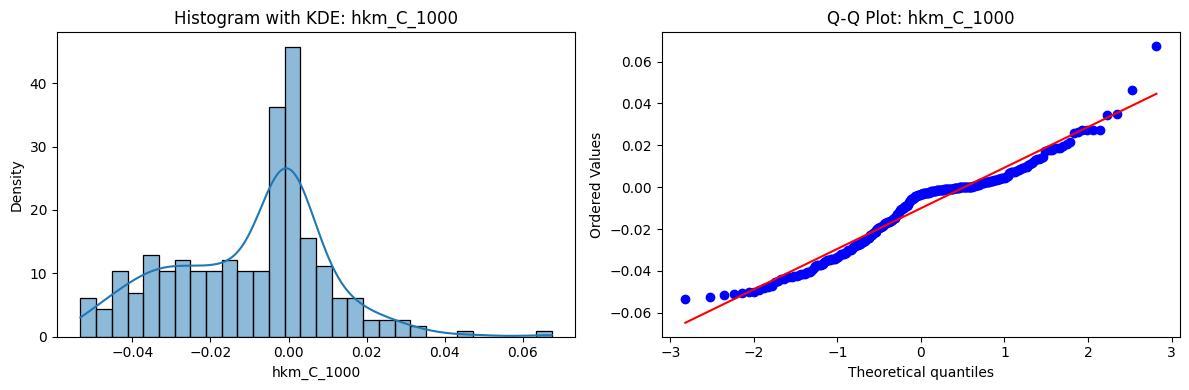

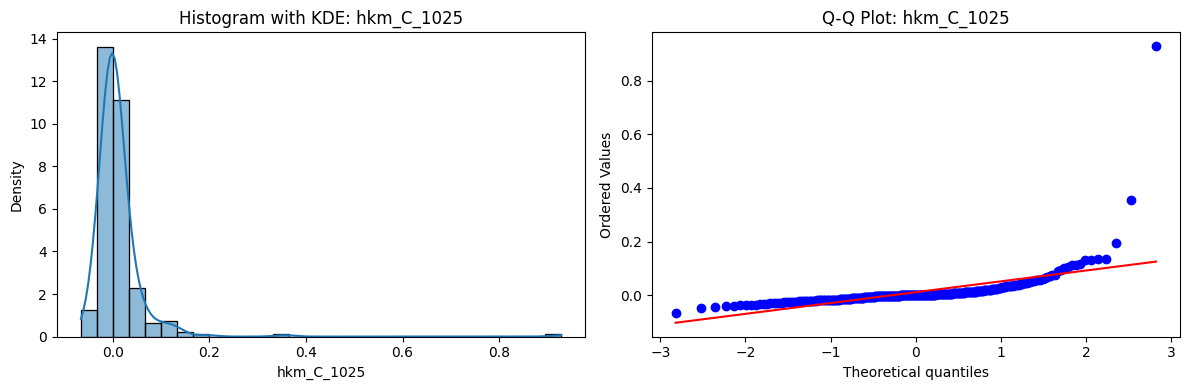

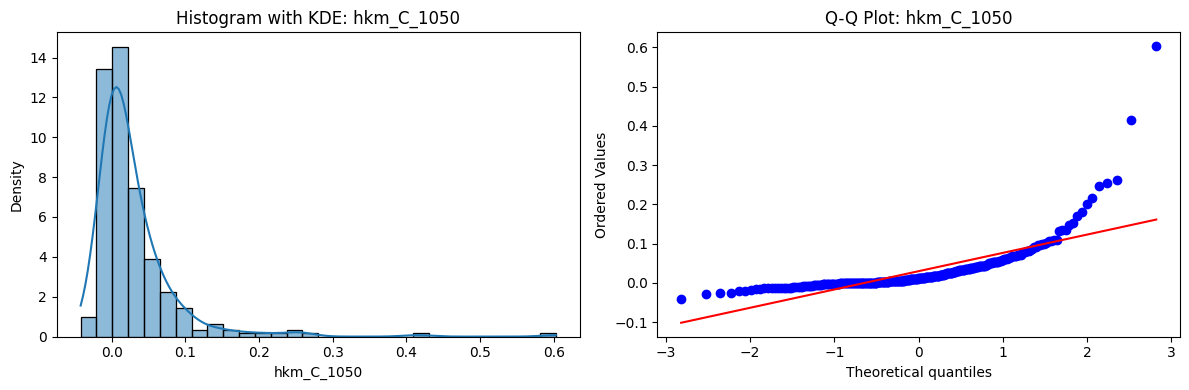

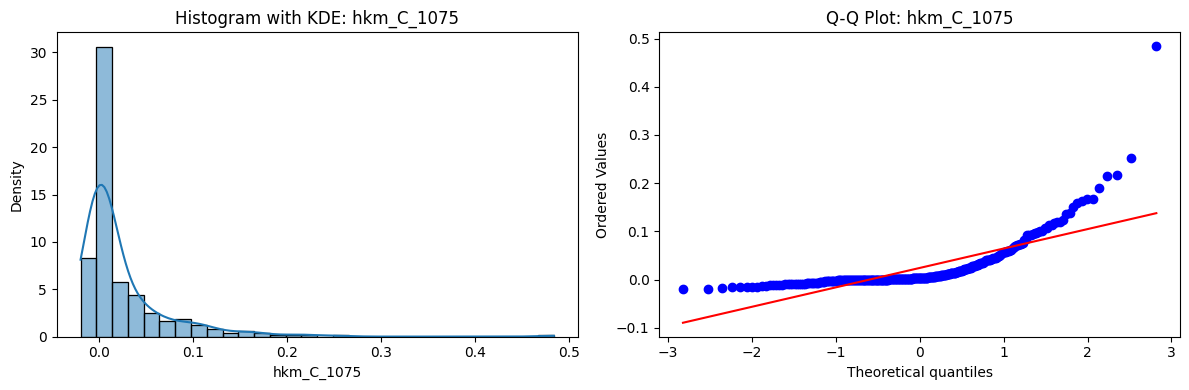

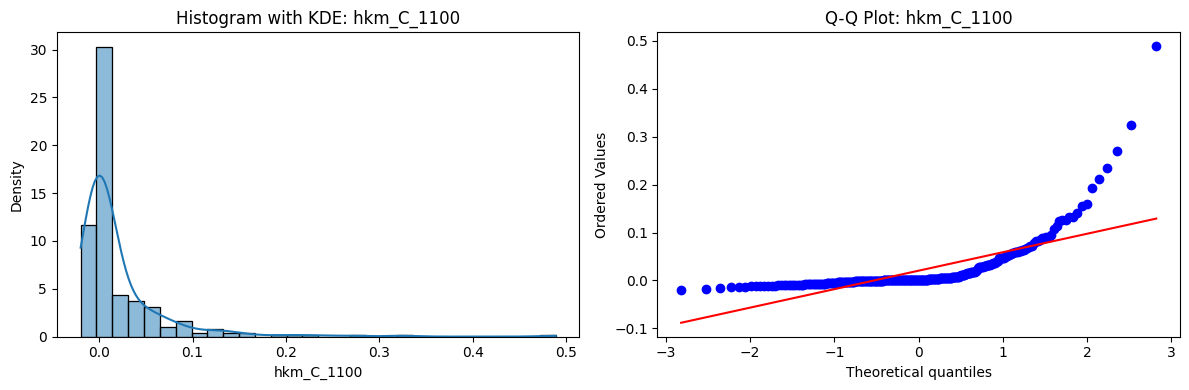

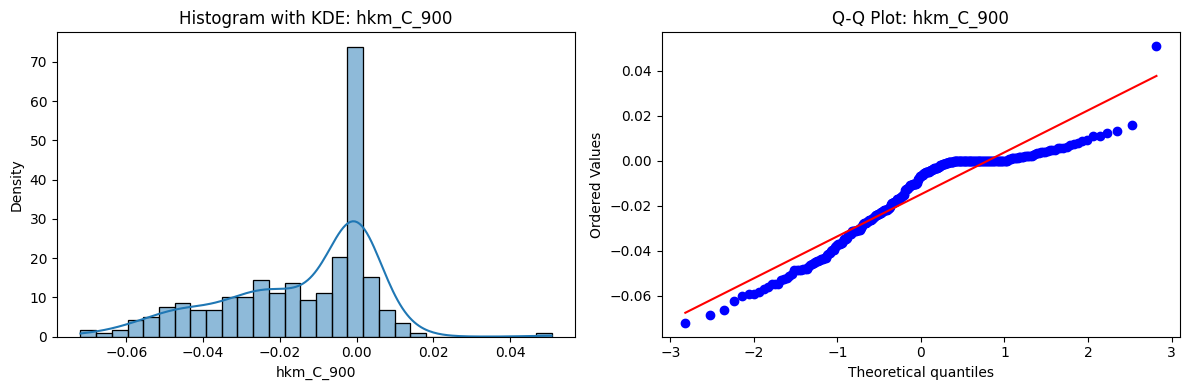

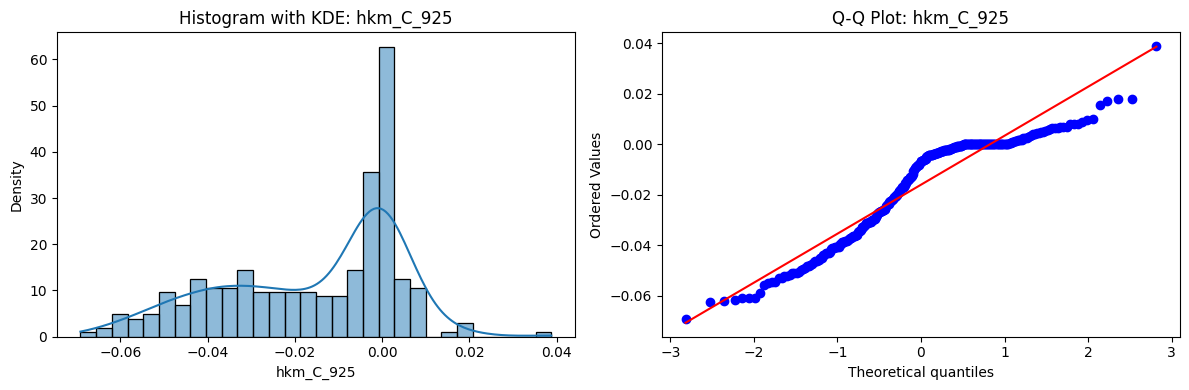

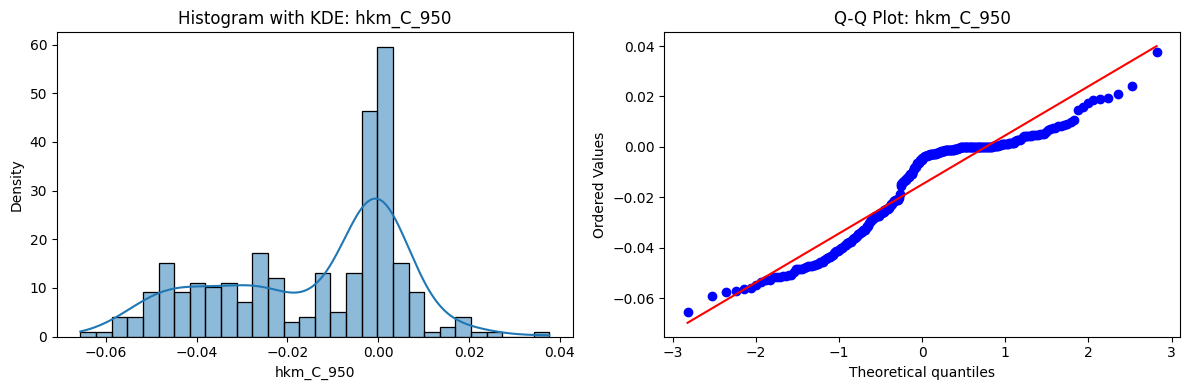

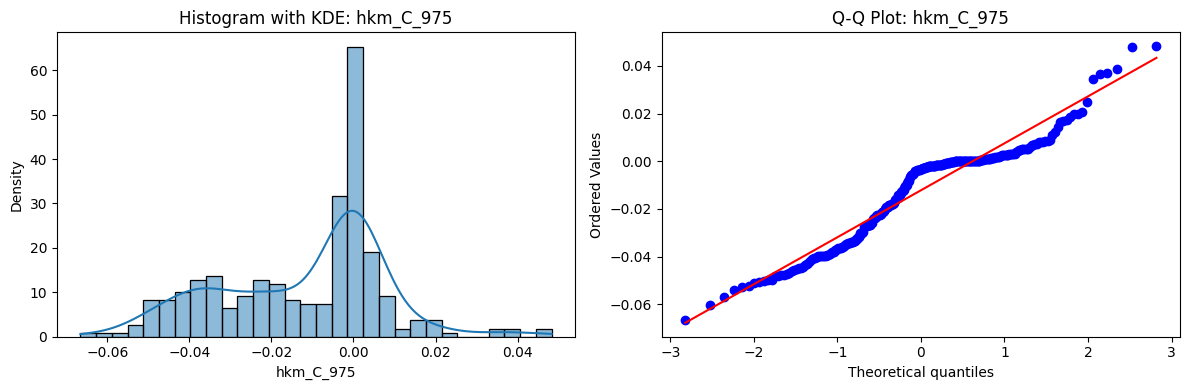

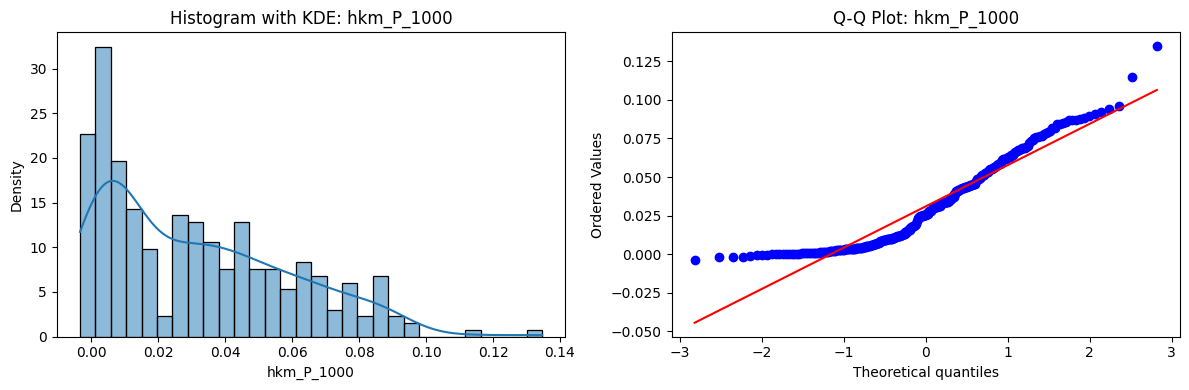

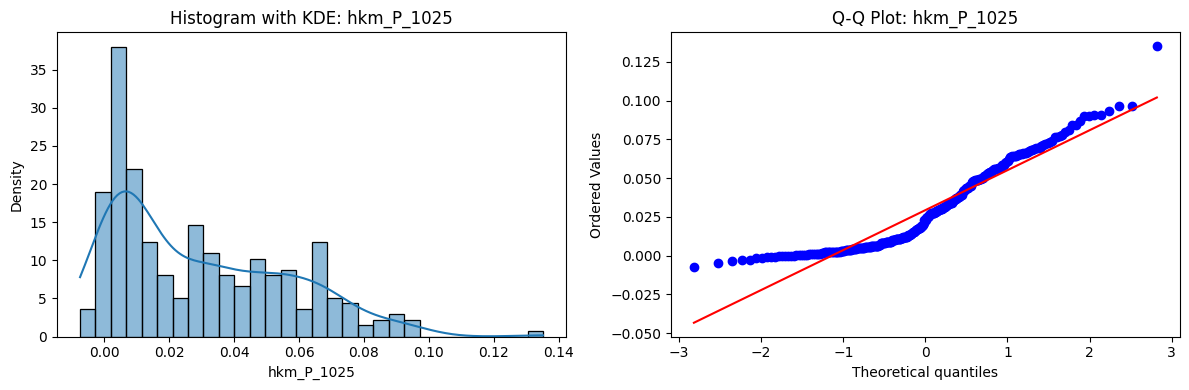

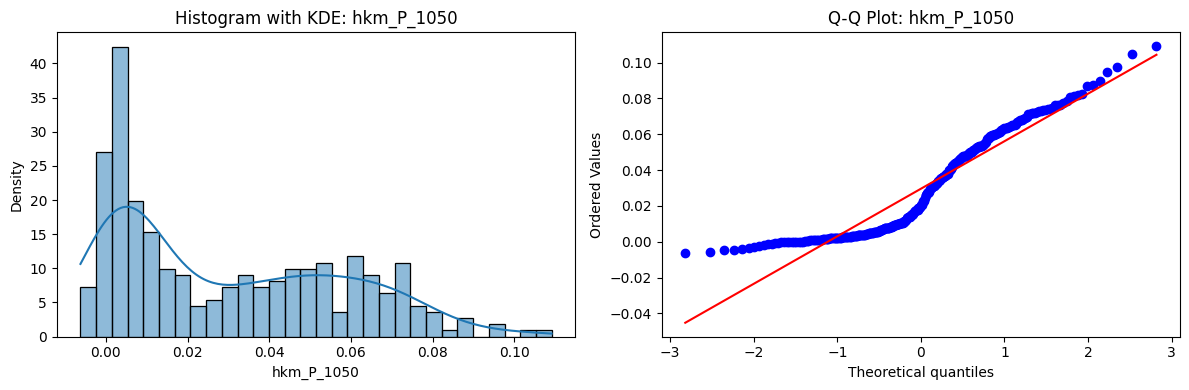

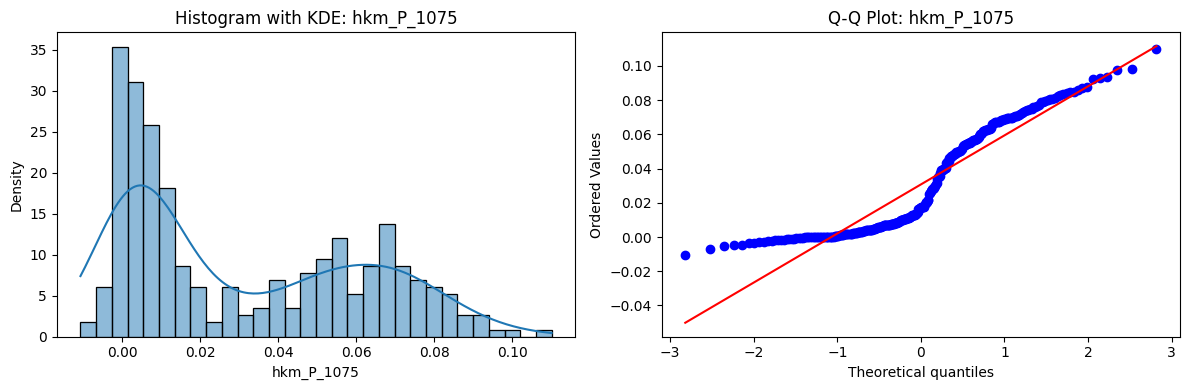

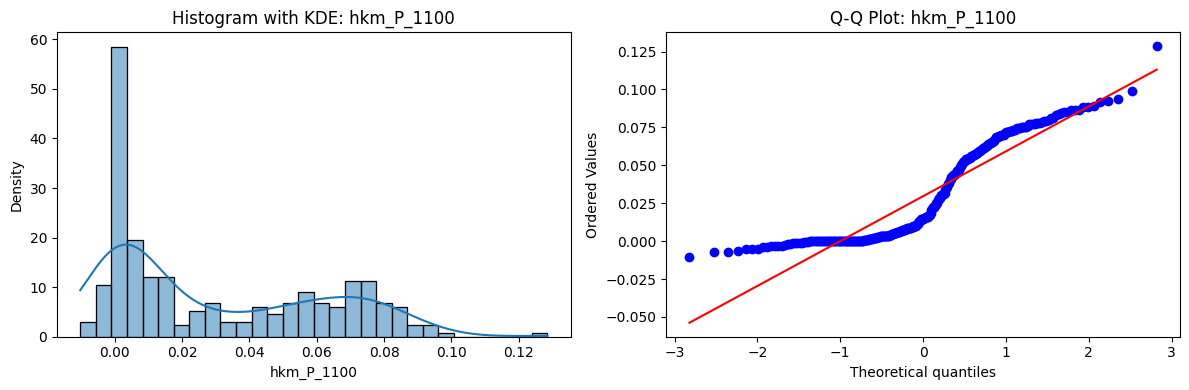

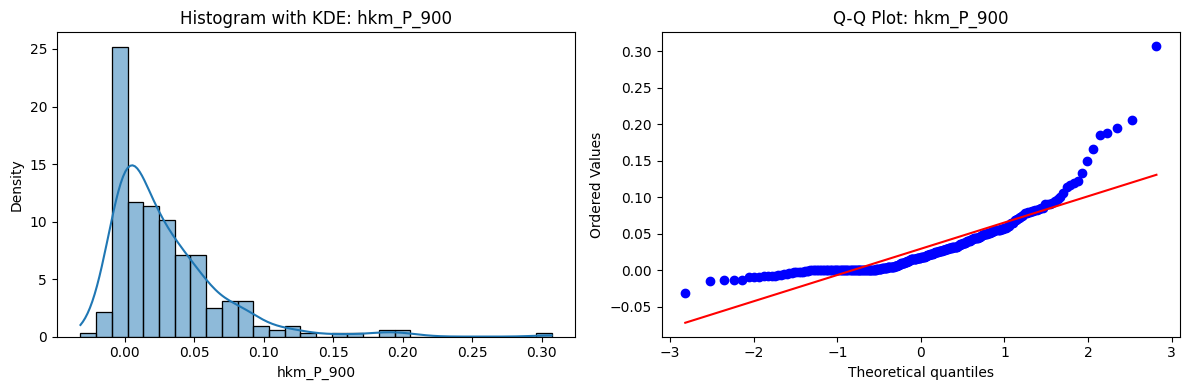

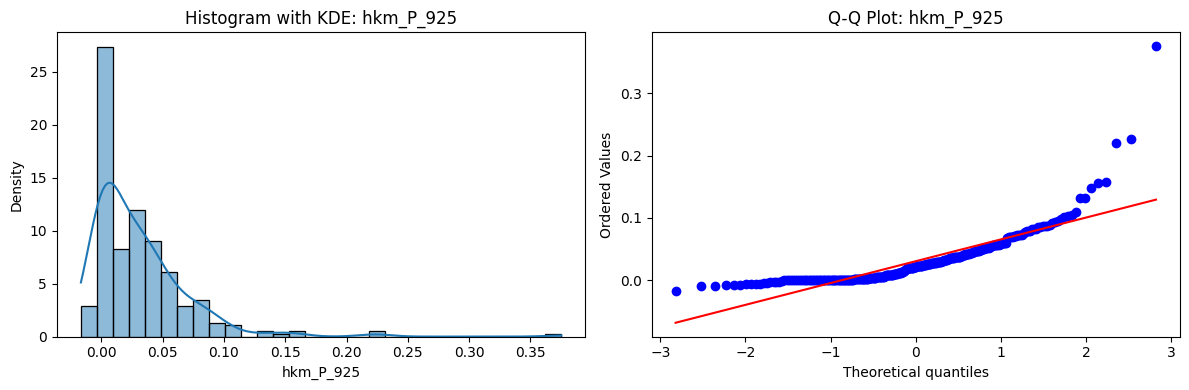

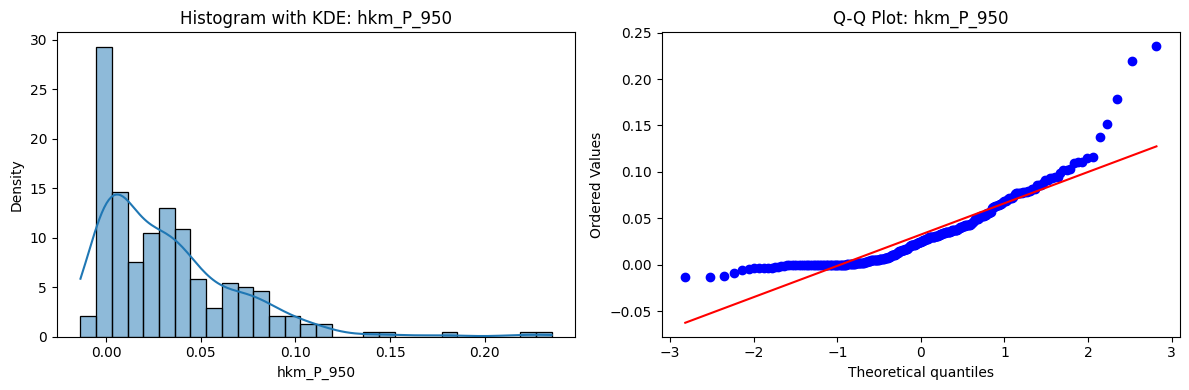

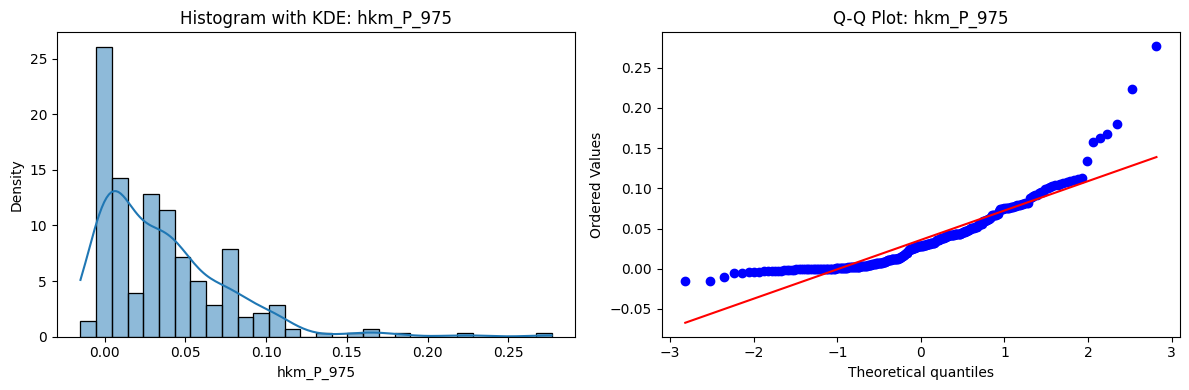

In [25]:
returns_df = test_data.copy()

# Apply to returns dataframe
summary_df = normality_summary(returns_df)
display(summary_df.style.format(na_rep="NaN", precision=2))

# Plot histogram and QQ plot for each series
for col in returns_df.columns:
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(returns_df[col].dropna(), kde=True, stat="density", bins=30, ax=axs[0])
    axs[0].set_title(f"Histogram with KDE: {col}")

    stats.probplot(returns_df[col].dropna(), dist="norm", plot=axs[1])
    axs[1].set_title(f"Q-Q Plot: {col}")

    plt.tight_layout()
    plt.show()

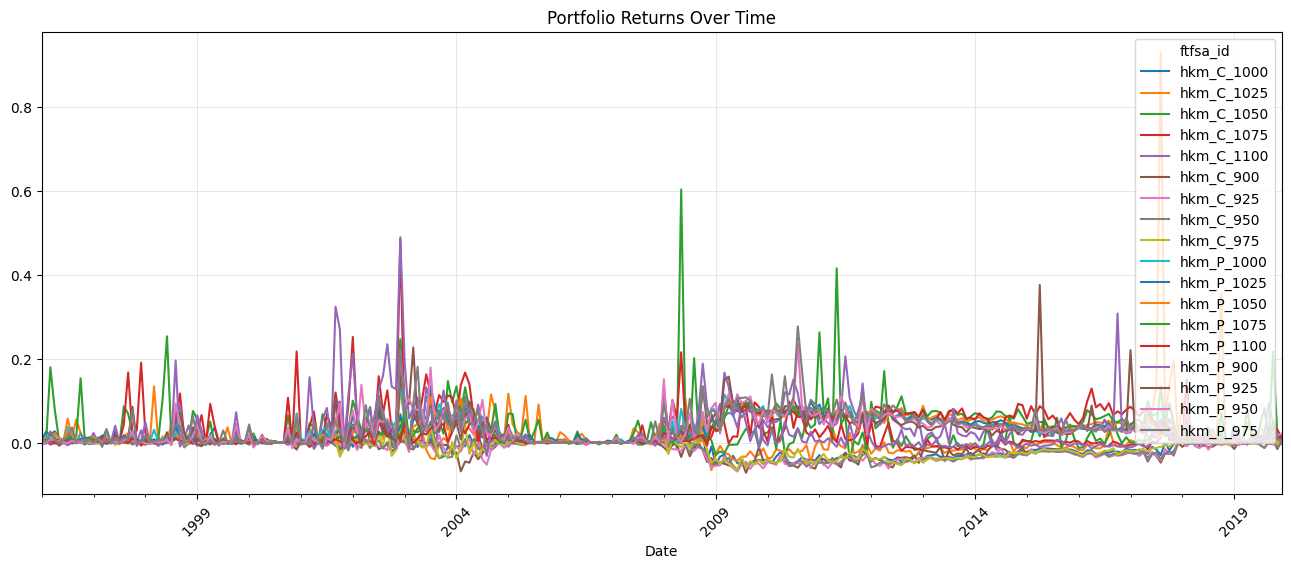

In [26]:
# plot groups of portfolios as line charts
portfolio_list = []  # ['hkm_C_1000', 'hkm_P_1000'],['cjs_P_950_30', 'cjs_P_1025_60', 'cjs_C_1000_90']

chart_data = test_data[portfolio_list] if portfolio_list else test_data

chart_data.plot(figsize=(16, 6), title="Portfolio Returns Over Time")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.gca().grid(True, which="major", color="#dddddd", linewidth=0.5)
plt.show()

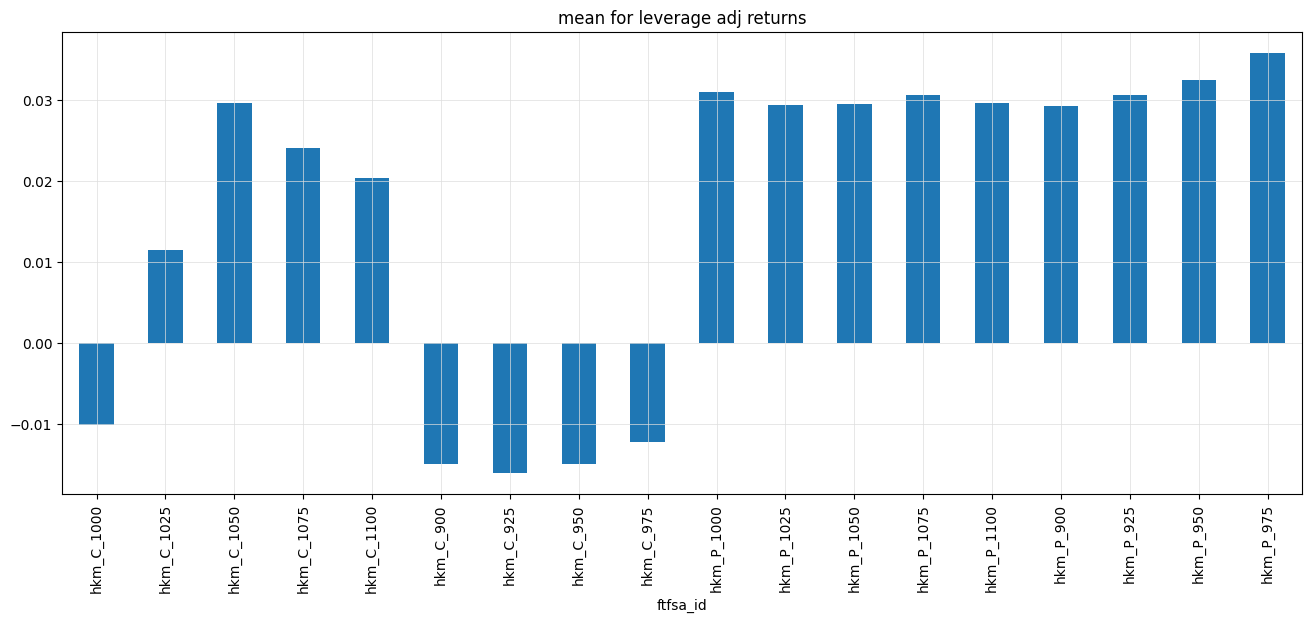

In [27]:
metric = "mean"
chart_data.describe().T[metric].plot(
    kind="bar", figsize=(16, 6), title=f"{metric} for leverage adj returns"
)
plt.gca().grid(True, which="major", color="#dddddd", linewidth=0.5)

plt.show()

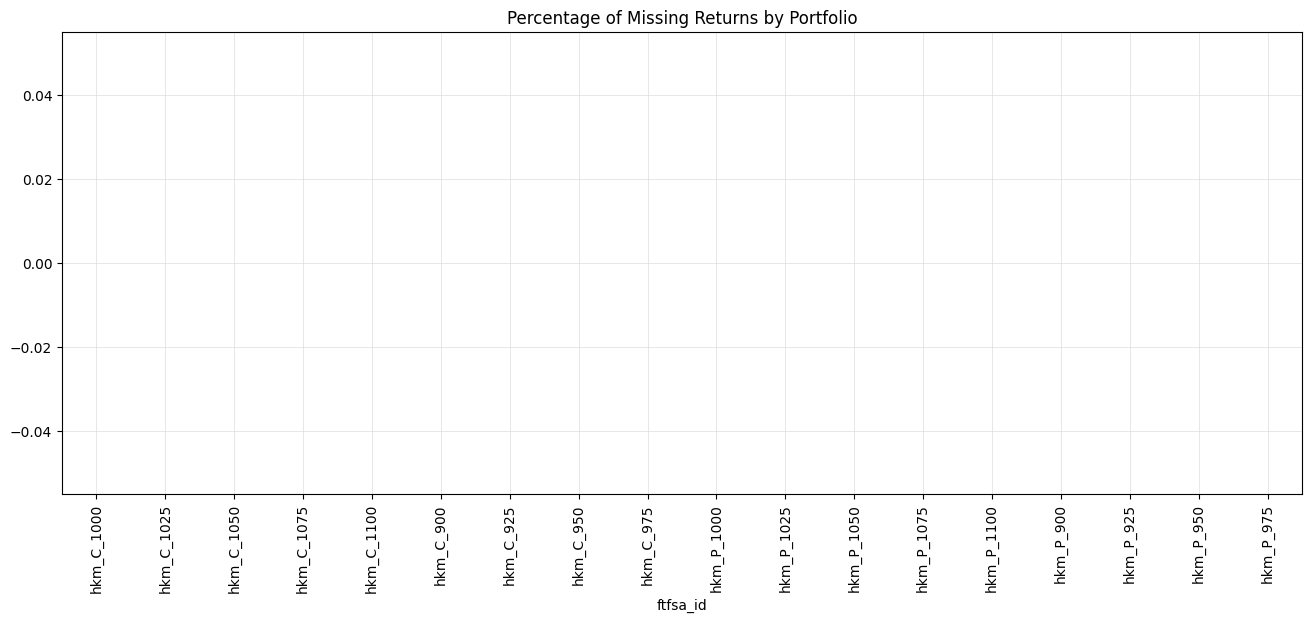

In [28]:
(test_data.isna().sum() / test_data.shape[0]).plot(
    kind="bar",
    color="lightblue",
    figsize=(16, 6),
    title="Percentage of Missing Returns by Portfolio",
)
plt.gca().grid(True, which="major", color="#dddddd", linewidth=0.5)
plt.show()

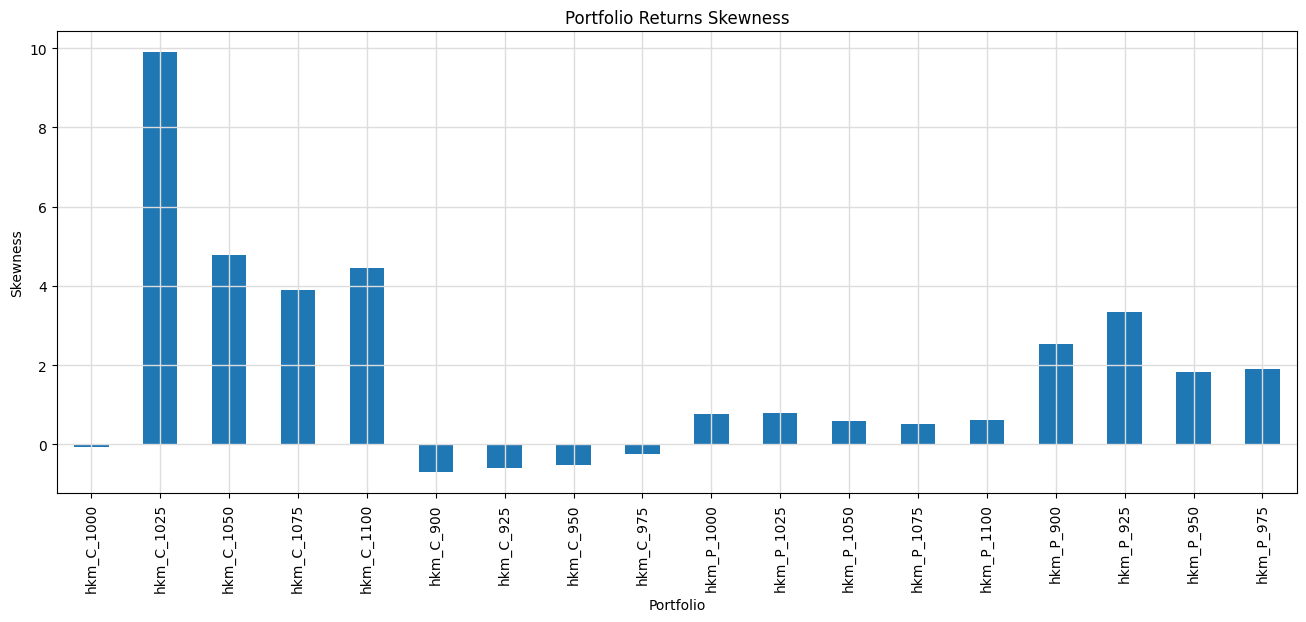

In [29]:
test_data.skew().plot(kind="bar").set_title("Portfolio Returns Skewness")
plt.xlabel("Portfolio")
plt.xticks(np.arange(len(test_data.columns)), test_data.columns, rotation=90)
plt.gca().grid(True, which="major", color="#dddddd", linewidth=1)
plt.gcf().set_size_inches(16, 6)
plt.ylabel("Skewness")
plt.show()

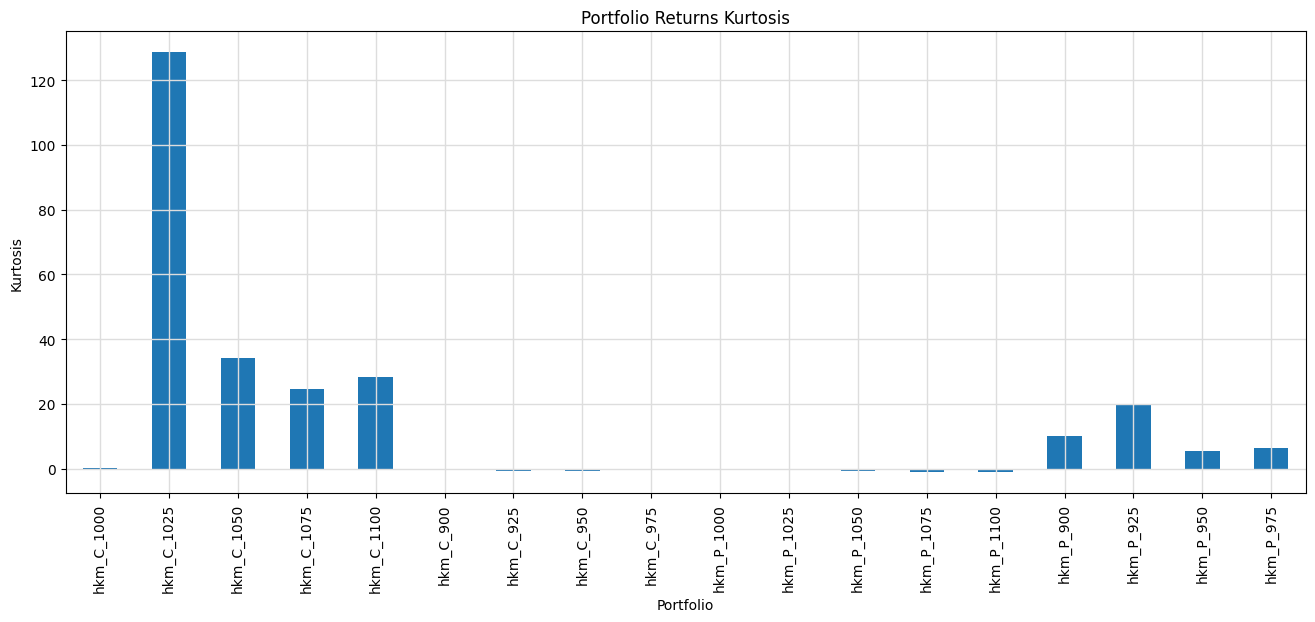

In [30]:
test_data.kurtosis().plot(kind="bar").set_title("Portfolio Returns Kurtosis")
plt.xlabel("Portfolio")
plt.xticks(np.arange(len(test_data.columns)), test_data.columns, rotation=90)
plt.gca().grid(True, which="major", color="#dddddd", linewidth=1)
plt.gcf().set_size_inches(16, 6)
plt.ylabel("Kurtosis")
# plt.yscale('log')  # Log scale for better visibility
plt.show()

### Testing NaN-filling logic

In [31]:
test = spx_mod.set_index(["date", "ftfsa_id"])
test.sort_index(inplace=True)
_cols = ["moneyness", "days_to_maturity_int", "kernel_weight", "exdate"]
test = test[_cols + [_ for _ in test.columns if _ not in _cols]]
test

moneyness  days_to_maturity_int  kernel_weight  \
date       ftfsa_id                                                    
1996-01-04 C_1000_30   0.987534                    16       0.412356   
           C_1000_30   0.979440                    44       0.175289   
           C_1000_30   0.987534                    44       0.412356   
           C_1025_30   1.019913                    16       1.000000   
           C_1050_30   1.028007                    16       0.282991   
...                         ...                   ...            ...   
2019-12-31 P_975_90    0.968806                    91       0.086212   
           P_975_90    0.970354                    91       0.090967   
           P_975_90    0.971902                    91       0.094524   
           P_975_90    0.973449                    91       0.096725   
           P_975_90    0.974997                    91       0.097473   

                         exdate     secid     open    close cp_flag        IV  \
date       ftfsa_id                                                             
1996-01-04 C_1000_30 1996-01-20  108105.0   621.32   617.70       C  0.082711   
           C_1000_30 1996-02-17  108105.0   621.32   617.70       C  0.090735   
           C_1000_30 1996-02-17  108105.0   621.32   617.70       C  0.092040   
           C_1025_30 1996-01-20  108105.0   621.32   617.70       C  0.097356   
           C_1050_30 1996-01-20  108105.0   621.32   617.70       C  0.101756   
...                         ...       ...      ...      ...     ...       ...   
2019-12-31 P_975_90  2020-03-31  108105.0  3215.18  3230.78       P  0.154539   
           P_975_90  2020-03-31  108105.0  3215.18  3230.78       P  0.153434   
           P_975_90  2020-03-31  108105.0  3215.18  3230.78       P  0.152282   
           P_975_90  2020-03-31  108105.0  3215.18  3230.78       P  0.151165   
           P_975_90  2020-03-31  108105.0  3215.18  3230.78       P  0.150000   

                      tb_m3  ...    log_iv  fitted_iv  rel_distance_iv  \
date       ftfsa_id          ...                                         
1996-01-04 C_1000_30   5.04  ... -2.492403  -2.377298         4.841838   
           C_1000_30   5.04  ... -2.399812  -2.443314        -1.780452   
           C_1000_30   5.04  ... -2.385532  -2.394781        -0.386203   
           C_1025_30   5.04  ... -2.329381  -2.285771         1.907866   
           C_1050_30   5.04  ... -2.285177  -2.264082         0.931727   
...                     ...  ...       ...        ...              ...   
2019-12-31 P_975_90    1.52  ... -1.867309  -1.885683        -0.974399   
           P_975_90    1.52  ... -1.874485  -1.891615        -0.905577   
           P_975_90    1.52  ... -1.882021  -1.897564        -0.819094   
           P_975_90    1.52  ... -1.889383  -1.903531        -0.743212   
           P_975_90    1.52  ... -1.897120  -1.909514        -0.649088   

                      moneyness_bin  stdev_iv_moneyness_bin  is_outlier_iv  \
date       ftfsa_id                                                          
1996-01-04 C_1000_30   (0.975, 1.0]                3.516840          False   
           C_1000_30   (0.975, 1.0]                3.516840          False   
           C_1000_30   (0.975, 1.0]                3.516840          False   
           C_1025_30   (1.0, 1.025]                5.219336          False   
           C_1050_30  (1.025, 1.05]                4.396845          False   
...                             ...                     ...            ...   
2019-12-31 P_975_90   (0.95, 0.975]                2.301503          False   
           P_975_90   (0.95, 0.975]                2.301503          False   
           P_975_90   (0.95, 0.975]                2.301503          False   
           P_975_90   (0.95, 0.975]                2.301503          False   
           P_975_90   (0.95, 0.975]                2.301503          False   

                      moneyness_id maturity_id  optio

In [32]:
daily_returns

ftfsa_id    C_1000_30  C_1000_60  C_1000_90  C_1025_30  C_1025_60  C_1025_90  \
date                                                                           
1996-01-04   0.002171        NaN        NaN   0.000198        NaN        NaN   
1996-01-05        NaN        NaN        NaN  -0.002985        NaN        NaN   
1996-01-09  -0.004362  -0.005736        NaN   0.011077   0.000193        NaN   
1996-01-10  -0.001291        NaN        NaN        NaN        NaN        NaN   
1996-01-22  -0.002792        NaN        NaN  -0.004186        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
2019-12-24        NaN        NaN        NaN  -0.001959        NaN        NaN   
2019-12-26   0.000177  -0.000588  -0.001565   0.049612   0.000451  -0.001096   
2019-12-27        NaN        NaN        NaN        NaN        NaN        NaN   
2019-12-30   0.000195  -0.000363  -0.000944   0.000539   0.000115  -0.001000   
2019-12-31   0.000164  -0.000746  -0.001073   0.000216  -0.000542  -0.001064   

ftfsa_id    C_1050_30  C_1050_60  C_1050_90  C_1075_30  ...  P_900_90  \
date                                                    ...             
1996-01-04  -0.003106        NaN        NaN        NaN  ...       NaN   
1996-01-05   0.004674        NaN        NaN        NaN  ...       NaN   
1996-01-09   0.039018   0.000195        NaN   0.008154  ...       NaN   
1996-01-10  -0.003064        NaN        NaN  -0.005087  ...       NaN   
1996-01-22   0.004054        NaN        NaN   0.016734  ...       NaN   
...               ...        ...        ...        ...  ...       ...   
2019-12-24        NaN        NaN        NaN        NaN  ...  0.000877   
2019-12-26   0.001201   0.000729        NaN   0.001499  ...  0.000925   
2019-12-27        NaN        NaN        NaN        NaN  ...  0.001085   
2019-12-30   0.001502  -0.000179  -0.001638   0.000554  ...  0.001061   
2019-12-31   0.000767  -0.000273  -0.000936   0.000142  ...  0.000913   

ftfsa_id    P_925_30  P_925_60  P_925_90  P_950_30  P_950_60  P_950_90  \
date                                                                     
1996-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
1996-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
1996-01-09       NaN       NaN       NaN       NaN  0.000191       NaN   
1996-01-10       NaN       NaN       NaN       NaN       NaN       NaN   
1996-01-22       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2019-12-24       NaN  0.000702 -0.003096       NaN       NaN  0.007690   
2019-12-26  0.000619  0.000816  0.001072  0.000456  0.000826  0.000696   
2019-12-27       NaN  0.000463  0.002847       NaN       NaN  0.002921   
2019-12-30  0.000485  0.000862  0.000741  0.000373  0.000779  0.000816   
2019-12-31  0.000537  0.000821  0.000914  0.000592  0.000825  0.000898   

ftfsa_id    P_975_30  P_975_60  P_975_90  
date                                      
1996-01-04  0.003393       NaN       NaN  
1996-01-05       NaN       NaN       NaN  
1996-01-09  0.011241  0.007766       NaN  
1996-01-10       NaN       NaN       NaN  
1996-01-22       NaN       NaN       NaN  
...              ...       ...       ...  
2019-12-24 -0.007144       NaN       NaN  
2019-12-26  0.002388  0.000837  0.000776  
2019-12-27       NaN       NaN       NaN  
2019-12-30  0.000222  0.000845  0.001032  
2019-12-31  0.000382  0.000766  0.000936  

[3740 rows x 54 columns]

In [33]:
test.loc[pd.IndexSlice["1996-01-04":"1996-01-10", "C_1000_30"], :]

moneyness  days_to_maturity_int  kernel_weight  \
date       ftfsa_id                                                    
1996-01-04 C_1000_30   0.987534                    16       0.412356   
           C_1000_30   0.979440                    44       0.175289   
           C_1000_30   0.987534                    44       0.412356   
1996-01-09 C_1000_30   0.976290                    39       0.112423   
           C_1000_30   0.984494                    39       0.314758   
           C_1000_30   0.992698                    39       0.572820   
1996-01-10 C_1000_30   0.977476                    10       0.272701   
           C_1000_30   0.985831                    10       0.727299   

                         exdate     secid    open   close cp_flag        IV  \
date       ftfsa_id                                                           
1996-01-04 C_1000_30 1996-01-20  108105.0  621.32  617.70       C  0.082711   
           C_1000_30 1996-02-17  108105.0  621.32  617.70       C  0.090735   
           C_1000_30 1996-02-17  108105.0  621.32  617.70       C  0.092040   
1996-01-09 C_1000_30 1996-02-17  108105.0  618.46  609.45       C  0.097121   
           C_1000_30 1996-02-17  108105.0  618.46  609.45       C  0.100478   
           C_1000_30 1996-02-17  108105.0  618.46  609.45       C  0.100392   
1996-01-10 C_1000_30 1996-01-20  108105.0  609.45  598.48       C  0.136584   
           C_1000_30 1996-01-20  108105.0  609.45  598.48       C  0.148282   

                      tb_m3  ...    log_iv  fitted_iv  rel_distance_iv  \
date       ftfsa_id          ...                                         
1996-01-04 C_1000_30   5.04  ... -2.492403  -2.377298         4.841838   
           C_1000_30   5.04  ... -2.399812  -2.443314        -1.780452   
           C_1000_30   5.04  ... -2.385532  -2.394781        -0.386203   
1996-01-09 C_1000_30   5.01  ... -2.331798  -2.388494        -2.373727   
           C_1000_30   5.01  ... -2.297816  -2.340017        -1.803411   
           C_1000_30   5.01  ... -2.298673  -2.297086         0.069066   
1996-01-10 C_1000_30   5.04  ... -1.990815  -1.917546         3.820998   
           C_1000_30   5.04  ... -1.908639  -1.958191        -2.530474   

                      moneyness_bin  stdev_iv_moneyness_bin  is_outlier_iv  \
date       ftfsa_id                                                          
1996-01-04 C_1000_30   (0.975, 1.0]                 3.51684          False   
           C_1000_30   (0.975, 1.0]                 3.51684          False   
           C_1000_30   (0.975, 1.0]                 3.51684          False   
1996-01-09 C_1000_30   (0.975, 1.0]                 3.51684          False   
           C_1000_30   (0.975, 1.0]                 3.51684          False   
           C_1000_30   (0.975, 1.0]                 3.51684          False   
1996-01-10 C_1000_30   (0.975, 1.0]                 3.51684          False   
           C_1000_30   (0.975, 1.0]                 3.51684          False   

                      moneyness_id maturity_id  option_delta  \
date       ftfsa_id                                            
1996-01-04 C_1000_30           1.0          30      0.805272   
           C_1000_30           1.0          30      0.807316   
           C_1000_30           1.0          30      0.725292   
1996-01-09 C_1000_30           1.0          30      0.826477   
           C_1000_30           1.0          30      0.743834   
           C_1000_30           1.0          30      0.656472   
1996-01-10 C_1000_30           1.0          30      0.859944   
           C_1000_30           1.0          30      0.742142   

                      option_elasticity  
date       ftfsa_id                      
1996-01-04 C_1000_30          48.826136  
           C_1000_30          28.094594  
           C_1000_30          31.717720  
1996-01-09 C_1000_30          28.578530  
           C_1000_30          32.094128  
           C_1000_30          36.789613  
1996-01-10 

In [34]:
test.loc[pd.IndexSlice["1996-01-04":"1996-01-10", "C_1025_30"], :]

moneyness  days_to_maturity_int  kernel_weight  \
date       ftfsa_id                                                    
1996-01-04 C_1025_30   1.019913                    16       1.000000   
1996-01-05 C_1025_30   1.021550                    15       1.000000   
1996-01-09 C_1025_30   1.000902                    11       0.023004   
           C_1025_30   1.017311                    11       0.122083   
           C_1025_30   1.000902                    39       0.093288   
           C_1025_30   1.009107                    39       0.266554   
           C_1025_30   1.017311                    39       0.495071   

                         exdate     secid    open   close cp_flag        IV  \
date       ftfsa_id                                                           
1996-01-04 C_1025_30 1996-01-20  108105.0  621.32  617.70       C  0.097356   
1996-01-05 C_1025_30 1996-01-20  108105.0  617.70  616.71       C  0.091355   
1996-01-09 C_1025_30 1996-01-20  108105.0  618.46  609.45       C  0.091177   
           C_1025_30 1996-01-20  108105.0  618.46  609.45       C  0.099723   
           C_1025_30 1996-02-17  108105.0  618.46  609.45       C  0.092492   
           C_1025_30 1996-02-17  108105.0  618.46  609.45       C  0.120972   
           C_1025_30 1996-02-17  108105.0  618.46  609.45       C  0.111577   

                      tb_m3  ...    log_iv  fitted_iv  rel_distance_iv  \
date       ftfsa_id          ...                                         
1996-01-04 C_1025_30   5.04  ... -2.329381  -2.285771         1.907866   
1996-01-05 C_1025_30   5.03  ... -2.393002  -2.383062         0.417130   
1996-01-09 C_1025_30   5.01  ... -2.394953  -2.364593         1.283913   
           C_1025_30   5.01  ... -2.305359  -2.368567        -2.668626   
           C_1025_30   5.01  ... -2.380633  -2.259703         5.351598   
           C_1025_30   5.01  ... -2.112196  -2.227867        -5.191982   
           C_1025_30   5.01  ... -2.193040  -2.201577        -0.387767   

                      moneyness_bin  stdev_iv_moneyness_bin  is_outlier_iv  \
date       ftfsa_id                                                          
1996-01-04 C_1025_30   (1.0, 1.025]                5.219336          False   
1996-01-05 C_1025_30   (1.0, 1.025]                5.219336          False   
1996-01-09 C_1025_30   (1.0, 1.025]                5.219336          False   
           C_1025_30   (1.0, 1.025]                5.219336          False   
           C_1025_30   (1.0, 1.025]                5.219336          False   
           C_1025_30   (1.0, 1.025]                5.219336          False   
           C_1025_30   (1.0, 1.025]                5.219336          False   

                      moneyness_id maturity_id  option_delta  \
date       ftfsa_id                                            
1996-01-04 C_1025_30         1.025          30      0.198018   
1996-01-05 C_1025_30         1.025          30      0.151415   
1996-01-09 C_1025_30         1.025          30      0.518470   
           C_1025_30         1.025          30      0.185260   
           C_1025_30         1.025          30      0.564481   
           C_1025_30         1.025          30      0.470463   
           C_1025_30         1.025          30      0.379971   

                      option_elasticity  
date       ftfsa_id                      
1996-01-04 C_1025_30          95.465702  
1996-01-05 C_1025_30         114.927948  
1996-01-09 C_1025_30          81.543671  
           C_1025_30         120.433497  
           C_1025_30          45.869738  
           C_1025_30          38.551087  
           C_1025_30          47.502205  

[7 rows x 30 columns]